# STGNN WAVE
Bunu implement ettim
https://github.com/dmlc/dgl/tree/master/examples/pytorch/stgcn_wave

Buna da bakmalıyım bi ara
https://github.com/chnsh/DCRNN_PyTorch

In [68]:
import dgl
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing import StandardScaler

[23:18:41] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.2.so: cannot open shared object file: No such file or directory
Using backend: pytorch


In [69]:
def data_transform(data, n_window, n_ahead, device=torch.device("cpu")):
    """
    :param data: rows for time indices, columns for locations
        currently does not support features
    :param n_window: history length
    :param n_ahead: next time index to predict
    """
    # produce data slices for training and testing
    n_obs, n_loc = data.shape
    
    num = n_obs - n_window - n_ahead
    x = np.zeros([num, 1, n_window, n_loc]) # features might end up being in second dimension
    y = np.zeros([num, n_loc])
    
    count = 0
    for start in range(num):
        x[count, :, :, :] = data[start: start + n_window].reshape(1, n_window, n_loc)
        y[count] = data[start + n_window + n_ahead - 1]
        count += 1
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [70]:
data = pd.read_parquet("data/wind/2019-01-24_outlier_removed.parquet")    
data = data[~data["rt_plant_id"].isin([2397, 2420, 2538])]
assert data.rt_plant_id.nunique() == 98
plant_mapping = {k:v for k,v in zip(np.sort(data.rt_plant_id.astype(int).unique()), range(98))}
data.rt_plant_id = data.rt_plant_id.map(plant_mapping) # zaten sort ettiği için gerek yok aslında


In [71]:
def generate_adjacency_matrix(df, threshold=0.5):    
    data = df[["forecast_dt", "rt_plant_id", "production"]]
    data = pd.pivot_table(data, index="forecast_dt", columns="rt_plant_id", values="production")

    A = abs(data.corr())
    A = A[A > threshold].fillna(0)
    return A

In [72]:
adj = generate_adjacency_matrix(data)
sp_mx = sp.coo_matrix(adj)
G = dgl.from_scipy(sp_mx, eweight_name="weight")

In [80]:
print(len(G.all_edges()[0]))
print(len(G.edata["weight"]))

5854
5854


In [81]:
data.head()

,epoch,production,rt_plant_id,forecast_dt,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,VGRD_80.m.above.ground.NE,VGRD_80.m.above.ground.SE,production_lower,production_upper,is_outlier,production_cleaned
0,1548288000,10.0,24,2019-01-24 03:00:00+03:00,-2.38199,-1.81199,-1.30199,-1.89199,17.6692,15.3592,15.56920,10.63920,0.0,10.0,False,10.0
1,1548291600,10.0,24,2019-01-24 04:00:00+03:00,-3.17761,-2.64761,-2.29761,-3.02761,16.5007,14.2907,14.46070,10.24070,0.0,10.0,False,10.0
2,1548295200,9.0,24,2019-01-24 05:00:00+03:00,-3.59330,-3.04330,-2.57330,-3.40330,15.6373,13.4373,13.17730,9.39729,0.0,10.0,False,9.0
3,1548298800,2.7,24,2019-01-24 06:00:00+03:00,-4.02746,-3.62746,-2.69746,-3.66746,14.3966,13.1466,11.37660,8.86664,0.0,10.0,False,2.7
4,1548302400,1.3,24,2019-01-24 07:00:00+03:00,-4.51297,-4.19297,-2.72297,-3.82297,13.0937,12.9637,9.64367,8.58367,0.0,10.0,False,1.3


In [82]:
df = pd.pivot_table(
    data[["production", "rt_plant_id", "forecast_dt"]], 
    index="forecast_dt", 
    columns="rt_plant_id", 
    values="production")

In [83]:
df = df.to_numpy()
if True:
    df = df[round(0.6*len(df)):round(0.7*len(df))]
num_samples, num_nodes = df.shape
print(num_samples, num_nodes)

2639 98


In [84]:
len_val = round(num_samples * 0.099)
len_train = round(num_samples * 0.9)
train = df[: len_train]
val = df[len_train: len_train + len_val]
test = df[len_train + len_val:]
print(len(train), len(val), len(test))

scaler = StandardScaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

2375 261 3


In [85]:
n_window, n_ahead = 5 * 24, 1
x_train, y_train = data_transform(train, n_window, n_ahead)
x_val, y_val = data_transform(val, n_window, n_ahead)
# x_test, y_test = data_transform(test, n_window, n_ahead)

In [46]:
batch_size = 50
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
# test_data = torch.utils.data.TensorDataset(x_test, y_test)
# test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [88]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

class TemporalConvLayer(nn.Module):
    ''' Temporal convolution layer.
    
    arguments
    ---------
    c_in : int
        The number of input channels (features)
    c_out : int
        The number of output channels (features)
    dia : int
        The dilation size
    '''
    def __init__(self, c_in, c_out, dia = 1):
        super(TemporalConvLayer, self).__init__()
        self.c_out = c_out
        self.c_in = c_in
        self.conv = nn.Conv2d(c_in, c_out, (2, 1), 1, dilation = dia, padding = (0,0))


    def forward(self, x):
        return torch.relu(self.conv(x))


class SpatioConvLayer(nn.Module):
    def __init__(self, c, Lk): # c : hidden dimension Lk: graph matrix
        super(SpatioConvLayer, self).__init__()
        self.g = Lk
        self.gc = GraphConv(c, c, activation=F.relu)

    def init(self):
        stdv = 1. / math.sqrt(self.W.weight.size(1))
        self.W.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = x.transpose(0, 3)
        x = x.transpose(1, 3)
        output = self.gc(self.g, x)
        output = output.transpose(1, 3)
        output = output.transpose(0, 3)
        return torch.relu(output)

class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConvLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class STGCN_WAVE(nn.Module):
    def __init__(self, c, T, n, Lk, device=torch.device("cpu"), control_str='TNTSTNTST'):
        super(STGCN_WAVE, self).__init__()
        self.control_str = control_str
        self.num_layers = len(control_str)
        self.layers = nn.ModuleList([])
        cnt = 0
        diapower = 0
        for i in range(self.num_layers):
            i_layer = control_str[i]
            if i_layer == 'T': # Temporal Layer
                self.layers.append(TemporalConvLayer(c[cnt], c[cnt + 1], dia = 2**diapower))
                diapower += 1
                cnt += 1
            if i_layer == 'S': # Spatio Layer
                self.layers.append(SpatioConvLayer(c[cnt], Lk))
            if i_layer == 'N': # Norm Layer
                self.layers.append(nn.LayerNorm([n,c[cnt]]))
        self.output = OutputLayer(c[cnt], T + 1 - 2**(diapower), n)
        for layer in self.layers:
            layer = layer.to(device)
    
    def forward(self, x):
        for i in range(self.num_layers):
            i_layer = self.control_str[i]
            if i_layer == 'N':
                x = self.layers[i](x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  
            else:
                x = self.layers[i](x)
        return self.output(x)

In [89]:
blocks = [1, 16, 32, 64, 32, 128]
lr = 0.001

In [90]:
loss = nn.MSELoss()
device=torch.device("cpu")
G = G.to(device)
model = STGCN_WAVE(blocks, n_window, num_nodes, G).to(device)

In [93]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)


In [97]:
save_path = "stgcnwavemodel.pt"
epochs = 10

def evaluate_model(model, loss, data_iter):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            l = loss(y_pred, y)
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n


def evaluate_metric(model, data_iter, scaler):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE

In [95]:
min_val_loss = np.inf
for epoch in range(1, epochs + 1):
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

    

/home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch 1 , train loss: 1.9522414689002676 , validation loss: 1.2319710893290383
epoch 2 , train loss: 0.5452193820381334 , validation loss: 0.8424148602145058
epoch 3 , train loss: 0.5066569461797124 , validation loss: 0.8159697694437844
epoch 4 , train loss: 0.46015106531615374 , validation loss: 0.9620197202478137
epoch 5 , train loss: 0.4417879204360806 , validation loss: 0.48036143822329386
epoch 6 , train loss: 0.3744976641122705 , validation loss: 0.5287078746727535
epoch 7 , train loss: 0.3958497392782196 , validation loss: 0.5174053949969155
epoch 8 , train loss: 0.4088760751903639 , validation loss: 0.65192911028862
epoch 9 , train loss: 0.3900070409914404 , validation loss: 0.5156211597578866
epoch 10 , train loss: 0.37422530703451534 , validation loss: 0.5958288609981537


In [ ]:
# adj matrixi train datadan oluştur

In [96]:
best_model = STGCN_WAVE(blocks, n_window, num_nodes, G).to(device)
best_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [99]:
l = evaluate_model(best_model, loss, val_iter)
MAE, MAPE, RMSE = evaluate_metric(best_model, val_iter, scaler)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

test loss: 0.48036143822329386 
MAE: 7.230481583400801 , MAPE: -784896.8272835218 , RMSE: 12.349392776566047


In [ ]:
model.eval()
l_sum, n = 0.0, 0
with torch.no_grad():
    for x, y in data_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    return l_sum / n


In [135]:
def plot(y, y_pred, i=0):
    y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
    y = scaler.inverse_transform(y.cpu().numpy())
    plt.plot(y[:, i], label="y")
    plt.plot(y_pred[:, i], label="y_pred")
    plt.legend()
    plt.show()

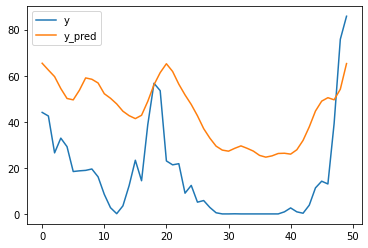

In [136]:
model.eval()
with torch.no_grad():
    x, y = list(val_iter)[0]
    y_pred = model(x).view(len(x), -1)
    plot(y, y_pred)
        

In [162]:
data[(data["rt_plant_id"] == 0) & (data["forecast_dt"] > "2019-02-15") & (data["forecast_dt"] < "2019-02-16")]

,epoch,production,rt_plant_id,forecast_dt,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,VGRD_80.m.above.ground.NE,VGRD_80.m.above.ground.SE,production_lower,production_upper,is_outlier,production_cleaned
2518980,1550181600,53.8,0,2019-02-15 01:00:00+03:00,-4.71441,-4.33441,-4.87441,-5.54441,-8.32122,-11.96120,-5.47122,-10.66120,0.0,90.0,False,53.8
2518981,1550185200,50.2,0,2019-02-15 02:00:00+03:00,-4.40230,-4.18230,-4.57230,-5.57230,-8.92716,-12.47720,-5.64716,-11.00720,0.0,90.0,False,50.2
2518982,1550188800,63.3,0,2019-02-15 03:00:00+03:00,-4.37219,-4.16219,-4.61219,-5.77219,-9.20763,-12.61760,-5.53763,-10.74760,0.0,90.0,False,63.3
2518983,1550192400,62.1,0,2019-02-15 04:00:00+03:00,-4.32540,-4.46540,-4.77540,-6.18540,-8.24631,-11.71630,-4.51631,-9.23631,0.0,90.0,False,62.1
2518984,1550196000,62.3,0,2019-02-15 05:00:00+03:00,-5.40853,-5.70853,-5.66853,-7.46853,-6.28855,-10.32850,-2.78854,-6.72854,0.0,90.0,False,62.3
2518985,1550199600,65.4,0,2019-02-15 06:00:00+03:00,-6.35776,-7.45776,-5.91776,-8.69776,-4.35393,-7.92393,-2.36393,-5.70393,0.0,90.0,False,65.4
2518986,1550203200,69.8,0,2019-02-15 07:00:00+03:00,-7.15247,-9.03247,-5.99247,-9.66247,-3.17254,-6.37254,-2.44254,-5.47254,0.0,90.0,False,69.8
2518987,1550206800,65.9,0,2019-02-15 08:00:00+03:00,-7.56750,-10.09750,-6.24750,-10.25750,-3.28948,-6.17948,-3.51948,-6.41948,0.0,90.0,False,65.9
2518988,1550210400,74.4,0,2019-02-15 09:00:00+03:00,-7.63459,-10.48460,-7.13459,-10.47460,-4.33782,-7.09782,-4.96782,-7.44782,0.0,90.0,False,74.4
2518989,1550214000,79.4,0,2019-02-15 10:00:00+03:00,-8.94495,-10.61500,-8.65495,-10.72500,-6.00667,-7.85667,-6.19667,-8.07667,0.0,90.0,False,79.4


In [161]:
data[(data["rt_plant_id"] == 0) & (abs(data["production"] - 65.39) <= 0.02)]

,epoch,production,rt_plant_id,forecast_dt,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,VGRD_80.m.above.ground.NE,VGRD_80.m.above.ground.SE,production_lower,production_upper,is_outlier,production_cleaned
2518985,1550199600,65.40,0,2019-02-15 06:00:00+03:00,-6.357760,-7.457760,-5.91776,-8.69776,-4.35393,-7.92393,-2.36393,-5.70393,0.0,90.0,False,65.40
2519360,1551549600,65.40,0,2019-03-02 21:00:00+03:00,-5.524380,-6.604380,-4.47438,-7.24438,-4.44314,-4.23314,-4.60314,-5.11314,0.0,90.0,False,65.40
2526527,1577361600,65.40,0,2019-12-26 15:00:00+03:00,-0.774015,-1.014020,-1.80402,-1.43402,-6.70117,-7.33117,-9.09117,-8.41117,0.0,90.0,False,65.40
2527294,1580122800,65.40,0,2020-01-27 14:00:00+03:00,1.789610,0.779612,2.52961,2.87961,4.87548,3.66548,6.94548,5.14548,0.0,90.0,False,65.40
2531065,1593698400,65.40,0,2020-07-02 17:00:00+03:00,-4.023950,-7.093960,-4.80396,-4.98395,-6.09874,-7.93874,-7.83874,-8.44874,0.0,90.0,False,65.40
2531134,1593946800,65.40,0,2020-07-05 14:00:00+03:00,-5.314030,-6.184030,-5.53403,-3.29403,-7.03359,-6.62359,-8.21359,-5.63359,0.0,90.0,False,65.40
2533004,1600678800,65.40,0,2020-09-21 12:00:00+03:00,-6.401600,-7.931600,-6.55160,-7.10160,-7.11232,-7.14232,-8.13232,-7.29232,0.0,90.0,False,65.40
2534237,1605117600,65.40,0,2020-11-11 21:00:00+03:00,-9.446380,-12.186400,-8.45638,-12.25640,-8.32726,-7.56726,-9.00726,-7.91726,0.0,90.0,False,65.40
2535757,1610589600,65.40,0,2021-01-14 05:00:00+03:00,-1.514910,0.425090,-2.23491,-0.76491,-5.01215,-7.07215,-5.72215,-4.73215,0.0,90.0,False,65.40
2540133,1626350400,65.38,0,2021-07-15 15:00:00+03:00,-7.116040,-5.846040,-7.16604,-3.44604,-6.85538,-5.26538,-8.09538,-4.85538,0.0,90.0,False,65.38


In [181]:
results = {}
for j in data.rt_plant_id.unique():
    m_ = data[(data["rt_plant_id"] == j)]["production"]
    results[j] = {}
    for i in range(len(m_) - 50):
        results[j][i] = np.sqrt(np.sum((m_[i: i + 50].values - n_) ** 2))

In [192]:
a_ = pd.melt(pd.DataFrame.from_dict(results).reset_index(), id_vars="index")
a_.columns = ["time", "rt_plant_id", "error"]

In [194]:
a_.sort_values("error")

,time,rt_plant_id,error
172368,14316,35,50.580916
2205741,19355,88,50.820785
172367,14315,35,51.004083
172369,14317,35,52.819343
829669,13067,39,53.423526
...,...,...,...
412353,17223,4,1594.420001
412694,17564,4,1594.502842
412352,17222,4,1598.727493
412350,17220,4,1600.650745


In [179]:
a_ = pd.DataFrame.from_records([results]).T.reset_index()
a_.columns = ["index", "error"]
a_.sort_values(by="error")

,index,error
13872,13872,77.547350
13871,13871,82.137394
13873,13873,82.784648
4337,4337,86.178723
6590,6590,86.309486
...,...,...
18625,18625,360.906706
18624,18624,361.116586
10342,10342,362.109709
10344,10344,363.190561


In [169]:
n_ = scaler.inverse_transform(y_pred)[:, 0]

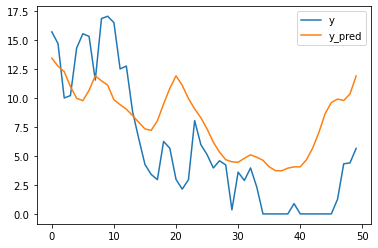

In [152]:
plot(y, y_pred, i=51)

In [112]:
y_pred.shape

torch.Size([50, 98])

In [114]:
a = scaler.inverse_transform(y_pred.cpu().numpy())
a

array([[65.397675  ,  0.54008514, 14.949546  , ..., 19.711016  ,
        23.82608   , 13.673688  ],
       [62.449398  ,  0.53487647, 14.217576  , ..., 18.834982  ,
        22.774855  , 13.01563   ],
       [59.593357  ,  0.5494486 , 13.503281  , ..., 18.089571  ,
        21.897104  , 12.456256  ],
       ...,
       [49.527992  ,  0.44908065, 11.734531  , ..., 16.164286  ,
        19.867104  , 11.57479   ],
       [54.12896   ,  0.46526167, 12.64662   , ..., 16.889395  ,
        20.657974  , 10.500264  ],
       [65.25539   ,  0.46546316, 15.137158  , ..., 19.061375  ,
        23.131285  , 10.023832  ]], dtype=float32)

In [115]:
a.shape

(50, 98)

In [116]:
b = scaler.inverse_transform(y.cpu().numpy())
b

array([[ 4.4060001e+01,  2.0000000e+00,  2.4999998e+00, ...,
         2.4549999e+01,  2.7000000e+01,  1.5300000e+01],
       [ 4.2500000e+01,  2.0000000e+00,  3.9000003e+00, ...,
         2.3170000e+01,  2.6000000e+01,  1.5300000e+01],
       [ 2.6499998e+01,  1.2874604e-08,  5.0000000e+00, ...,
         2.3600000e+01,  2.6000000e+01,  1.4700000e+01],
       ...,
       [ 3.9200001e+01,  1.0000000e+00,  3.3999999e+00, ...,
         1.8160000e+01,  2.4000000e+01, -3.9849533e-07],
       [ 7.5800003e+01,  1.2874604e-08,  4.6999998e+00, ...,
         2.3190001e+01,  3.0000000e+01, -3.9849533e-07],
       [ 8.5800003e+01,  1.2874604e-08,  5.6999998e+00, ...,
         2.2850000e+01,  2.9000000e+01, -3.9849533e-07]], dtype=float32)

In [123]:
b[:, 0]


array([4.4060001e+01, 4.2500000e+01, 2.6499998e+01, 3.2900002e+01,
       2.9199999e+01, 1.8400000e+01, 1.8700001e+01, 1.8900000e+01,
       1.9500000e+01, 1.6099998e+01, 8.5000019e+00, 2.6999993e+00,
       1.0000082e-01, 3.5000024e+00, 1.2299999e+01, 2.3299999e+01,
       1.4400000e+01, 3.8700001e+01, 5.6700001e+01, 5.3500000e+01,
       2.3000000e+01, 2.1299999e+01, 2.1799999e+01, 9.0000019e+00,
       1.2380001e+01, 5.1000009e+00, 5.8000016e+00, 2.7999978e+00,
       5.0000232e-01, 2.3436214e-06, 2.3436214e-06, 4.9997766e-02,
       2.3436214e-06, 2.3436214e-06, 2.3436214e-06, 2.3436214e-06,
       2.3436214e-06, 2.3436214e-06, 2.3436214e-06, 9.0000004e-01,
       2.5999970e+00, 9.0000004e-01, 3.0000159e-01, 3.8000016e+00,
       1.1299997e+01, 1.4199999e+01, 1.3000000e+01, 3.9200001e+01,
       7.5800003e+01, 8.5800003e+01], dtype=float32)

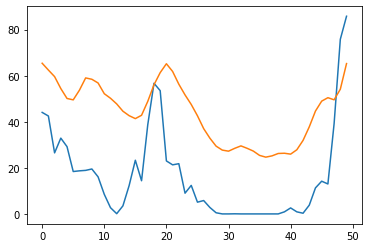

In [127]:
import matplotlib.pyplot as plt

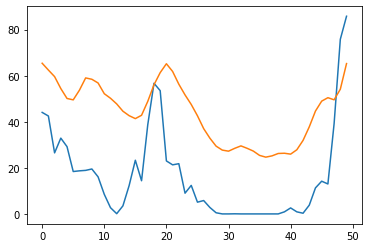